Let's have a look at how to implement a logistic regression model in Python. First, we need to import the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, roc_curve
pd.set_option('display.max_columns', 50) # Display up to 50 columns

Let's download the dataset automatically, unzip it, and place it in a folder called `data` if you haven't done so already

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os.path

# Check if the file exists
if not os.path.isfile('data/card_transdata.csv'):

    print('Downloading dataset...')

    # Define the dataset to be downloaded
    zipurl = 'https://www.kaggle.com/api/v1/datasets/download/dhanushnarayananr/credit-card-fraud'

    # Download and unzip the dataset in the data folder
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('data')

    print('DONE!')

else:

    print('Dataset already downloaded!')

DONE!


Then, we can load the data into a DataFrame using the `read_csv` function from the `pandas` library

In [3]:
df = pd.read_csv('data/card_transdata.csv')

Note that it is common to call this variable `df` which is short for DataFrame.

This is a **dataset of credit card transactions** from [Kaggle.com](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data). The target variable $y$ is `fraud`, which indicates whether the transaction is fraudulent or not. The other variables are the features $x$ of the transactions.


### Data Exploration & Preprocessing

The first step whenever you load a new dataset is to familiarize yourself with it. You need to understand what the variables represent, what the target variable is, and what the data looks like. This is called **data exploration**. Depending on the dataset, you might need to preprocess it (e.g., check for missing values and duplicates, or create new variables) before you can use it to train a machine-learning model. This is called **data preprocessing**.

#### Basic Dataframe Operations {-}

Let's see how many rows and columns the dataset has

In [4]:
df.shape

(1000000, 8)

The dataset has 1 million rows (observations) and 8 columns (variables)! Now, let's have a look at the first few rows of the dataset with the `head()` method

In [5]:
df.head().T

,0,1,2,3,4
distance_from_home,57.877857,10.829943,5.091079,2.247564,44.190936
distance_from_last_transaction,0.311140,0.175592,0.805153,5.600044,0.566486
ratio_to_median_purchase_price,1.945940,1.294219,0.427715,0.362663,2.222767
repeat_retailer,1.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,0.000000,0.000000,0.000000,0.000000,0.000000
online_order,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,0.000000,0.000000,0.000000,0.000000,0.000000


If you would like to see more entries in the dataset, you can use the `head()` method with an argument corresponding to the number of rows, e.g.,

In [6]:
df.head(20)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


Note that analogously you can also use the `tail()` method to see the last few rows of the dataset.

We can also check what the variables in our dataset are called

In [7]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

and the data types of the variables

In [8]:
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

In this case, all our variables are floating-point numbers (`float`). This means that they are numbers that have a fractional part such as 1.5, 3.14, etc. The number after `float`, `64` in this case refers to the number of bits that are used to represent this number in the computer's memory. With 64 bits you can store more decimals than you could with, for example, 32, meaning that the results of computations can be more precise. But for the topics discussed in this course, this is not very important. Other common data types that you might encounter are integers (`int`) such as 1, 3, 5, etc., or strings (`str`) such as `'hello'`, `'world'`, etc.

Let's dig deeper into the dataset and see some summary statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


With the `describe()` method we can see the count, mean, standard deviation, minimum, 25th percentile, median, 75th percentile, and maximum values of each variable in the dataset.


#### Checking for Missing Values and Duplicated Rows {-}

It is also important to check for missing values and duplicated rows in the dataset. Missing values can be problematic for machine learning models, as they might not be able to handle them. Duplicated rows can also be problematic, as they might introduce bias in the model.

We can check for missing values (NA) that are encoded as None or `numpy.NaN` (Not a Number) with the `isna()` method. This method returns a boolean DataFrame (i.e., a DataFrame with `True` and `False` values) with the same shape as the original DataFrame, where `True` values indicate missing values.

In [10]:
df.isna()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
999995,False,False,False,False,False,False,False,False
999996,False,False,False,False,False,False,False,False
999997,False,False,False,False,False,False,False,False
999998,False,False,False,False,False,False,False,False


or to make it easier to see, we can sum the number of missing values for each variable

In [11]:
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Luckily, there seem to be no missing values. However, you need to be careful! Sometimes missing values are encoded as empty strings `''` or `numpy.inf` (infinity), which are not considered missing values by the `isna()` method. If you suspect that this might be the case, you need to make additional checks.

As an alternative, we could also look at the `info()` method, which provides a summary of the DataFrame, including the number of non-null values in each column. If there are missing values, the number of non-null values will be less than the number of rows in the dataset.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


We can also check for duplicated rows with the `duplicated()` method. 

In [13]:
df.loc[df.duplicated()]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud


Luckily, there are also no duplicated rows.


#### Data Visualization {-}

Let's continue with some data visualization. We can use the `matplotlib` library to create plots. We have already imported the library at the beginning of the notebook.

Let's start by plotting the distribution of the target variable `fraud` which can only take values zero and one. We can type

In [14]:
df['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

to get the count of each value. We can also use the `normalize=True` argument to get the fraction of observations instead of the count

In [15]:
df['fraud'].value_counts(normalize=True)

fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64

We can then plot it as follows

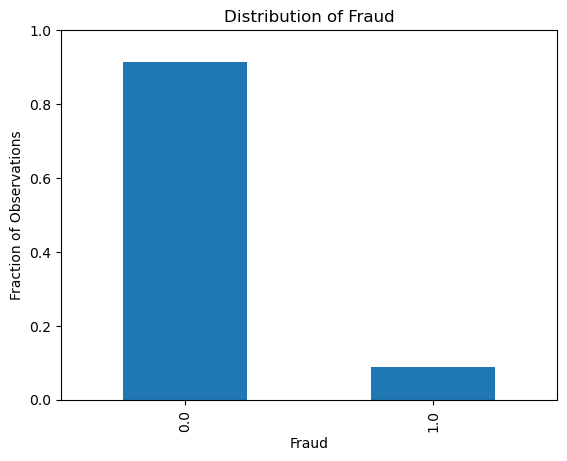

In [16]:
df['fraud'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Fraction of Observations')
plt.title('Distribution of Fraud')
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()

Alternatively, we can plot it as a pie chart

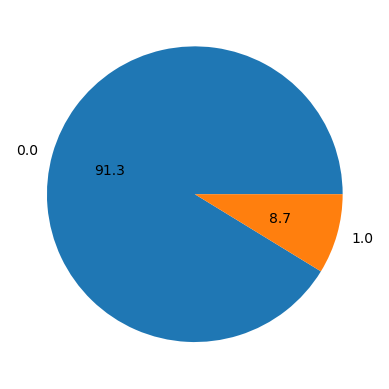

In [17]:
df.value_counts("fraud").plot.pie(autopct = "%.1f")
plt.ylabel('')
plt.show()

Our dataset seems to be quite imbalanced, as only 8.7% of the transactions are fraudulent. This is a common problem in fraud detection datasets, as fraudulent transactions are usually very rare. We will need to **keep this in mind** when evaluating our machine learning model: the accuracy measure will be very high even for bad models, as the model can just predict that all transactions are not fraudulent and still get an accuracy of 91.3%.

Let's look at some distributions. Most of the variables in the dataset are binary (0 or 1) variables. However, we also have some continuous variables. Let's plot the distribution of the variable `ratio_to_median_purchase_price`, which is a continuous variable.

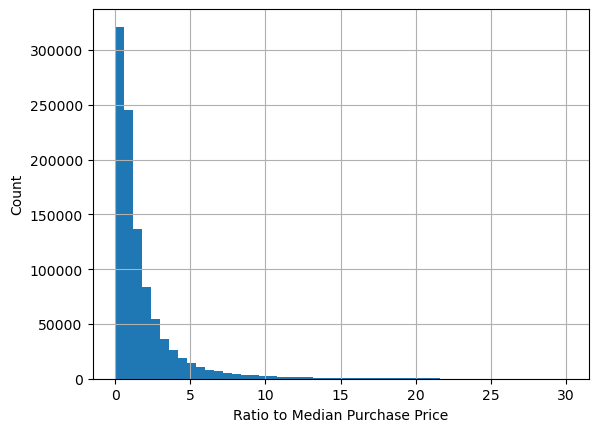

In [18]:
df['ratio_to_median_purchase_price'].hist(bins = 50, range=[0, 30])
plt.xlabel('Ratio to Median Purchase Price')
plt.ylabel('Count')
plt.show()

We can also plot the distribution of the variable `ratio_to_median_purchase_price` by the target variable `fraud` to see if there are any differences between fraudulent and non-fraudulent transactions

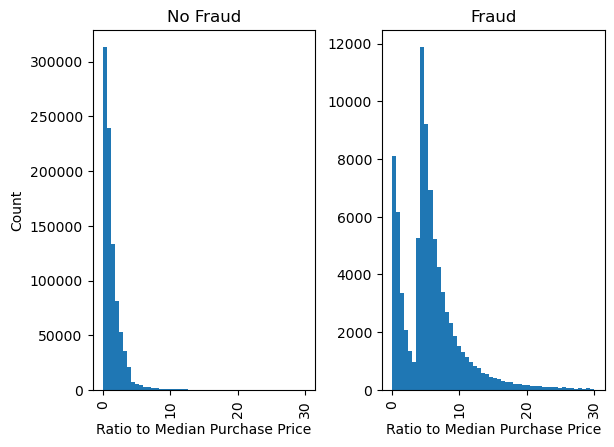

In [19]:
fig, ax = plt.subplots(1,2)
df['ratio_to_median_purchase_price'].hist(bins = 50, range=[0, 30], by=df['fraud'], ax = ax)
ax[0].set_xlabel('Ratio to Median Purchase Price')
ax[1].set_xlabel('Ratio to Median Purchase Price')
ax[0].set_ylabel('Count')
ax[0].set_title('No Fraud')
ax[1].set_title('Fraud')
plt.show()

There are indeed some differences between fraudulent and non-fraudulent transactions. For example, fraudulent transactions seem to have a higher ratio to the median purchase price, which is expected as fraudsters might try to make large transactions to maximize their profit.

We can also look at the correlation between the variables in the dataset. The correlation is a measure of how two variables move together

In [20]:
df.corr() # Pearson correlation (for linear relationships)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


In [21]:
df.corr('spearman') # Spearman correlation (for monotonic relationships)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,-0.001068,-0.000152,0.559724,-0.000118,-0.000338,-0.001812,0.095032
distance_from_last_transaction,-0.001068,1.000000,-0.000111,-0.001352,-0.000165,0.000555,-0.001076,0.034661
ratio_to_median_purchase_price,-0.000152,-0.000111,1.000000,0.001202,-0.000099,0.000251,-0.000376,0.342838
repeat_retailer,0.559724,-0.001352,0.001202,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000118,-0.000165,-0.000099,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.000338,0.000555,0.000251,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001812,-0.001076,-0.000376,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.095032,0.034661,0.342838,-0.001357,-0.060975,-0.100293,0.191973,1.000000


This is still a bit hard to read. We can visualize the correlation matrix with a heatmap using the Seaborn library, which we have already imported at the beginning of the notebook.

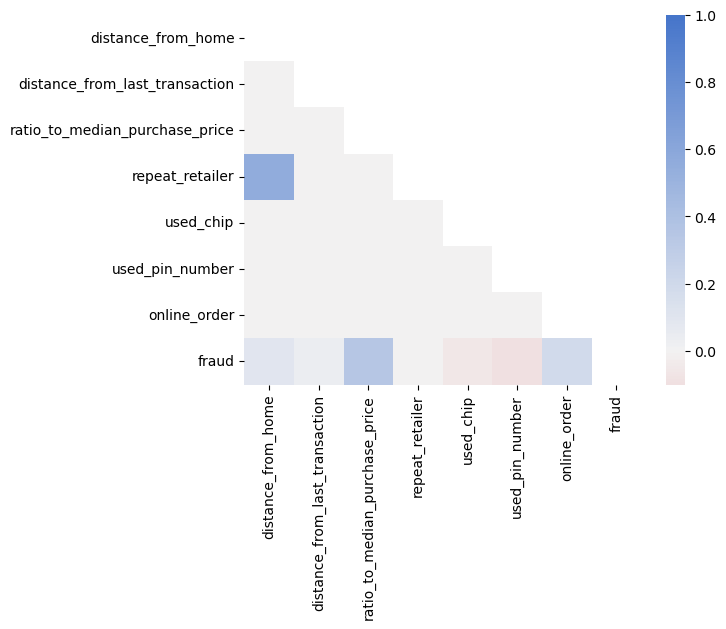

In [22]:
corr = df.corr('spearman')
cmap = sns.diverging_palette(10, 255, as_cmap=True) # Create a color map
mask = np.triu(np.ones_like(corr, dtype=bool)) # Create a mask to only show the lower triangle of the matrix
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, mask=mask) # Create a heatmap of the correlation matrix (Note: vmax=1 makes sure that the color map goes up to 1 and center=0 are used to center the color map at 0)
plt.show()

Note how `ratio_to_median_purchase_price` is positively correlated with `fraud`, which is expected as we saw in the previous plot that fraudulent transactions have a higher ratio to the median purchase price. Furthermore, `used_chip` and `used_pin_number` are negatively correlated with `fraud`, which makes sense as transactions, where the chip or the pin is used, are supposed to be more secure.

We can also plot boxplots to visualize the distribution of the variables

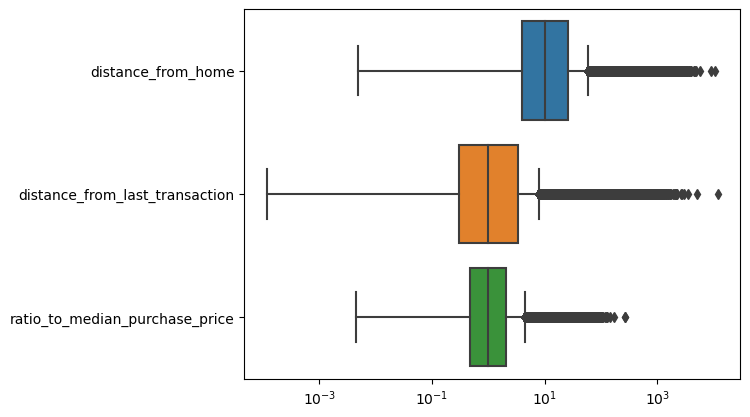

In [23]:
selector = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] # Select the variables we want to plot
plt.figure()
ax = sns.boxplot(data = df[selector], orient = 'h') 
ax.set(xscale = "log") # Set the x-axis to a logarithmic scale to better visualize the data
plt.show()

Boxplots are a good way to visualize the distribution of a variable, as they show the median, the interquartile range, and the outliers. Each of the distributions shown in the boxplots above has a long right tail, which explains the large number of outliers. However, you have to be careful: you cannot just remove these outliers since these are likely to be fraudulent transactions.

Let's see how many fraudulent transactions we would remove if we blindly remove the outliers according to the interquartile range

In [24]:
# Compute the interquartile range
Q1 = df['ratio_to_median_purchase_price'].quantile(0.25)
Q3 = df['ratio_to_median_purchase_price'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers based on the interquartile range
threshold = 1.5
outliers = df[(df['ratio_to_median_purchase_price'] < Q1 - threshold * IQR) | (df['ratio_to_median_purchase_price'] > Q3 + threshold * IQR)]

# Count the number of fraudulent transactions amoung our selected outliers
outliers['fraud'].value_counts()

fraud
1.0    53092
0.0    31294
Name: count, dtype: int64

In [25]:
df['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

53092 of 87403 (more than half!) of our fraudulent transactions would be removed if we would have blindly removed the outliers according to the interquartile range. This is a significant number of observations, which would likely hurt the performance of our machine-learning model. Therefore, we should not remove these outliers. It would make the imbalance of our dataset even worse.


#### Splitting the Data into Training and Test Sets {-}

Before we can train a machine learning model, we need to split our dataset into a training set and a test set. 

In [26]:
X = df.drop('fraud', axis=1) # All variables except `fraud`
y = df['fraud'] # Only our fraud variables

The training set is used to train the model, while the test set is used to evaluate the model. We will use the `train_test_split` function from the `sklearn.model_selection` module to split our dataset. We will use 70% of the data for training and 30% for testing. We will also set the `stratify` argument to `y` to make sure that the distribution of the target variable is the same in the training and test sets. Otherwise, we might randomly not have any fraudulent transactions in the test set, which would make it impossible to correctly evaluate our model.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

#### Scaling Features  {-}

To improve the performance of our machine learning model, we should scale the features. This is especially important for models that are sensitive to the scale of the features, such as logistic regression. We will use the `StandardScaler` class from the `sklearn.preprocessing` module to scale the features. The `StandardScaler` class scales the features so that they have a mean of 0 and a standard deviation of 1. Since we don't want to scale features that are binary (0 or 1), we will define a small function that scales only the features that we want

In [28]:
def scale_features(scaler, df, col_names, only_transform=False):

    # Extract the features we want to scale
    features = df[col_names] 

    # Fit the scaler to the features and transform them
    if only_transform:
        features = scaler.transform(features.values)
    else:
        features = scaler.fit_transform(features.values)

    # Replace the original features with the scaled features
    df[col_names] = features

Then, we need to run the function

In [29]:
col_names = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] 
scaler = StandardScaler() 
scale_features(scaler, X_train, col_names)
scale_features(scaler, X_test, col_names, only_transform=True)

Note that we only fit the scaler to the training set and then transform both the training and test set. This ensures that the same values for the features produce the same output in the training and test set. Otherwise, if we fit the scaler to the test data as well, the meaning of certain values in the test set might change, which would make it impossible to evaluate the model correctly.

:::{.callout-note}
### Mini-Exercise
Try switching to `MinMaxScaler` instead of `StandardScaler` and see how it affects the performance of the model. `MinMaxScaler` scales the features so that they are between 0 and 1.
:::


### Implementing Logistic Regression

Now that we have explored and preprocessed our dataset, we can move on to the next step: training a machine learning model. We will use a logistic regression model to predict whether a transaction is fraudulent or not.

Using the `LogisticRegression` class from the `sklearn.linear_model` module, fitting the model to the data is straightforward using the `fit` method

In [30]:
clf = LogisticRegression().fit(X_train, y_train)

We can then use the `predict` method to predict the class of the test set

In [31]:
clf.predict(X_test.head(5))

array([0., 0., 0., 0., 1.])

The actual classes of the first five observations in the test dataset are

In [32]:
y_test.head(5)

217309    0.0
902387    0.0
175152    0.0
527113    0.0
973041    1.0
Name: fraud, dtype: float64

This seems to match quite well. Let's have a look at different performance metrics

In [33]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba[:, 1])}")

Accuracy: 0.95908
Precision: 0.8954682094038908
Recall: 0.6021128103428549
ROC AUC: 0.9671832218100465


As expected, the accuracy is quite high since we do not have many fraudulent transactions. Recall that the precision ($\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$) is the fraction of correctly predicted fraudulent transactions among all transactions transactions predicted to be fraudulent. The recall ($\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$) is the fraction of correctly predicted fraudulent transactions among the actual fraudulent transactions. The ROC AUC is the area under the curve for the receiver operating characteristic (ROC) curve

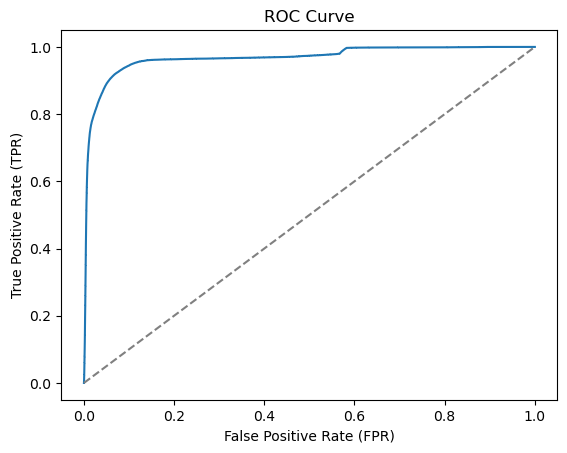

In [34]:
# Compute the ROC curve
y_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

The confusion matrix for the test set can be computed as follows

In [35]:
conf_mat = confusion_matrix(y_test, y_pred, labels=[1, 0]).transpose() # Transpose the sklearn confusion matrix to match the convention in the lecture
conf_mat

array([[ 15788,   1843],
       [ 10433, 271936]])

We can also plot the confusion matrix as a heatmap

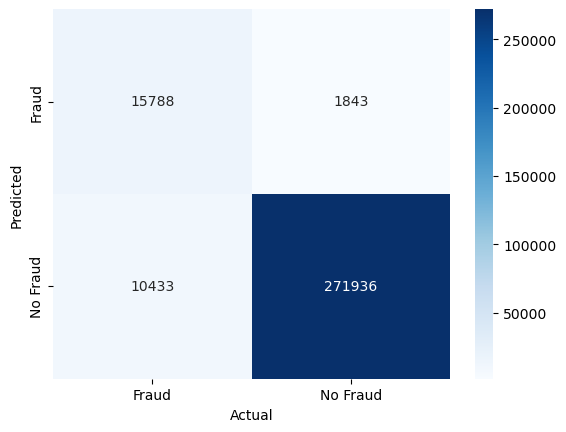

In [36]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Fraud', 'No Fraud'], yticklabels=['Fraud', 'No Fraud'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

As you can see, we have mostly true negatives and true positives. However, there is still a significant number of false negatives, which means that we are missing fraudulent transactions, and a significant number of false positives, which means that we are predicting transactions as fraudulent that are not fraudulent.

If we would like to use a threshold other than 0.5 to predict the class of the test set, we can do so as follows

In [37]:
# Alternative threshold
threshold = 0.1

# Predict the class of the test set
y_pred_alt = (y_proba[:, 1] >= threshold).astype(int)

# Show the performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_alt)}")
print(f"Precision: {precision_score(y_test, y_pred_alt)}")
print(f"Recall: {recall_score(y_test, y_pred_alt)}")

Accuracy: 0.9112033333333334
Precision: 0.49579121188932296
Recall: 0.9389420693337401


Setting a lower threshold increases the recall but decreases the precision. This is because we are more likely to predict a transaction as fraudulent, which increases the number of true positives but also the number of false positives.

What the correct threshold is depends on the problem at hand. For example, if the cost of missing a fraudulent transaction is very high, you might want to set a lower threshold to increase the recall. If the cost of falsely predicting a transaction as fraudulent is very high, you might want to set a higher threshold to increase the precision.

We can also plot the performance metrics for different thresholds

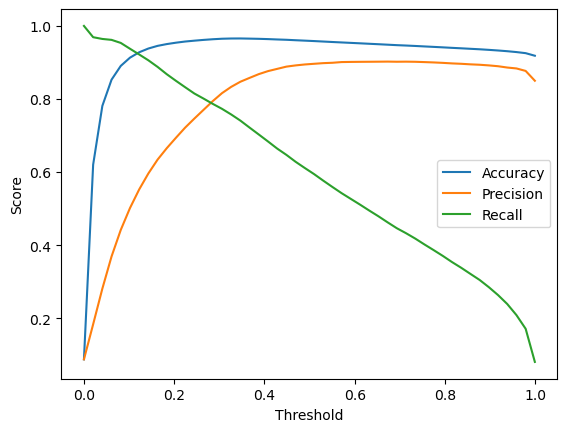

In [38]:
N = 50
thresholds_array = np.linspace(0.0, 0.999, N)
accuracy_array = np.zeros(N)
precision_array = np.zeros(N)
recall_array = np.zeros(N)

# Compute the performance metrics for different thresholds
for ii, thresh in enumerate(thresholds_array):
    y_pred_alt_tmp = (y_proba[:, 1] > thresh).astype(int)
    accuracy_array[ii] = accuracy_score(y_test, y_pred_alt_tmp)
    precision_array[ii] = precision_score(y_test, y_pred_alt_tmp)
    recall_array[ii] = recall_score(y_test, y_pred_alt_tmp)

# Plot the performance metrics
plt.plot(thresholds_array, accuracy_array, label='Accuracy')
plt.plot(thresholds_array, precision_array, label='Precision')
plt.plot(thresholds_array, recall_array, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

### Conclusions

In this notebook, we have seen how to implement a logistic regression model in Python. We have loaded a dataset, explored and preprocessed it, and trained a logistic regression model to predict whether a transaction is fraudulent or not. We have evaluated the model using different performance metrics and have seen how the choice of threshold affects the performance of the model.

There are many ways to improve the performance of the model. For example, we could try different machine learning models, or engineer new features. We could also try to deal with the imbalanced dataset by using techniques such as oversampling or undersampling. However, this is beyond the scope of this notebook.


<!--
Potential Datasets:

- Audit Data (https://www.kaggle.com/datasets/sid321axn/audit-data)
- Credit Card Fraud Detection (https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data)
- Bank Account Fraud (https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022)

Beginner datasets:
https://www.kaggle.com/discussions/getting-started/196714

-->